# **Classifying products in Semiconductor Industry**

#### **Import the data**

In [1]:
import mercury as mr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from mlxtend.plotting import plot_confusion_matrix

In [2]:
app = mr.App(title="Secom Web App Demo", description="Recumpute everything dynamically", continuous_update=False)

mercury.App

In [3]:
# Read the features data from the the url of csv into pandas dataframes and rename the columns to F1, F2, F3, etc.
# Read the labels data from the url of csv into pandas dataframes and rename the columns to pass/fail and date/time

#url_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
#url_labels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'

url_data = 'secom_data.csv'
url_labels = 'secom_labels.csv'

features = pd.read_csv(url_data,  delimiter=' ', header=None)
labels = pd.read_csv(url_labels,  delimiter=' ', names=['pass/fail', 'date_time'])

prefix = 'F'
new_column_names = [prefix + str(i) for i in range(1, len(features.columns)+1)]
features.columns = new_column_names

labels['pass/fail'] = labels['pass/fail'].replace({-1: 0, 1: 1})


#### **Split the data**

In [4]:
# if there is a date/time column, drop it from the features and labels dataframes, else continue

if 'date_time' in labels.columns:
    labels = labels.drop(['date_time'], axis=1)


# Split the dataset and the labels into training and testing sets
# use stratify to ensure that the training and testing sets have the same percentage of pass and fail labels
# use random_state to ensure that the same random split is generated each time the code is run

test_size_num = mr.Text(label="Test Size Ratio", value='0.25')          # 
test_size_num = float(test_size_num.value)

random_state_num = mr.Text(label="Random State Integer", value='13')          # 
random_state_num = int(random_state_num.value)


X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size = test_size_num, stratify=labels, random_state=random_state_num)



mercury.Text

mercury.Text

#### **Feature Removal**

In [5]:
def columns_to_drop(df,drop_duplicates='yes', missing_values_threshold=100, variance_threshold=0, 
                   correlation_threshold=1.1):
   
   global feature_removal_report0
   global feature_removal_report1
   global feature_removal_report2
   global feature_removal_report3
   global feature_removal_report4
   global feature_removal_report5
   global feature_removal_report6
   
  
   feature_removal_report0 = 'Shape of the dataframe is:' , df.shape

    # Drop duplicated columns
   if drop_duplicates == 'yes':
      new_column_names = df.columns
      df = df.T.drop_duplicates().T
      feature_removal_report1 = 'the number of columns dropped due to duplications is: ', len(new_column_names) - len(df.columns)
      drop_duplicated = list(set(new_column_names) - set(df.columns))

   elif drop_duplicates == 'no':
      df = df.T.T
      feature_removal_report1 = 'No columns were dropped due to duplications' 

   # Print the percentage of columns in df with missing values more than or equal to threshold
   feature_removal_report2 = 'the number of columns dropped due to missing values is: ', len(df.isnull().mean()[df.isnull().mean() > missing_values_threshold/100].index)
      
   # Print into a list the columns to be dropped due to missing values
   drop_missing = list(df.isnull().mean()[df.isnull().mean() > missing_values_threshold/100].index)

   # Drop columns with more than or equal to threshold missing values from df
   df.drop(drop_missing, axis=1, inplace=True)
    
   # Print the number of columns in df with variance less than threshold
   feature_removal_report3 = 'the number of columns dropped due to low variance is: ', len(df.var()[df.var() <= variance_threshold].index)

   # Print into a list the columns to be dropped due to low variance
   drop_variance = list(df.var()[df.var() <= variance_threshold].index)

   # Drop columns with more than or equal to threshold variance from df
   df.drop(drop_variance, axis=1, inplace=True)

   # Print the number of columns in df with more than or equal to threshold correlation
      
   # Create correlation matrix and round it to 4 decimal places
   corr_matrix = df.corr().abs().round(4)
   upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
   to_drop = [column for column in upper.columns if any(upper[column] >= correlation_threshold)]
   feature_removal_report4 = 'the number of columns dropped due to high correlation is: ', len(to_drop)

   # Print into a list the columns to be dropped due to high correlation
   drop_correlation = [column for column in upper.columns if any(upper[column] >= correlation_threshold)]

   # Drop columns with more than or equal to threshold correlation from df
   df.drop(to_drop, axis=1, inplace=True)
   
   if drop_duplicates == 'yes':
      dropped = (drop_duplicated+drop_missing+drop_variance+drop_correlation)

   elif drop_duplicates =='no':
      dropped = (drop_missing+drop_variance+drop_correlation)
   
   feature_removal_report5 = 'Total number of columns to be dropped is: ', len(dropped)
   feature_removal_report6 = 'New shape of the dataframe is: ', df.shape

   global drop_duplicates_var
   drop_duplicates_var = drop_duplicates
   
   global missing_values_threshold_var
   missing_values_threshold_var = missing_values_threshold

   global variance_threshold_var
   variance_threshold_var = variance_threshold

   global correlation_threshold_var
   correlation_threshold_var = correlation_threshold
   
   return dropped

#### **Outlier Removal**

In [6]:
def outlier_removal(z_df, action = 'ignore', z_threshold=3):
    
    global outlier_var
    global outlier_removal_report0
    global outlier_removal_report1

    if action == 'ignore':
        outlier_removal_report0 = 'No z-score threshold was selected'
        outlier_var = 'none'
        z_df_copy = z_df.copy()
        outlier_removal_report1 = 'No outliers were removed from the dataset'
    
    if action == 'remove':
                
        outlier_removal_report0 = 'The z-score threshold is:', z_threshold

        z_df_copy = z_df.copy()

        z_scores = np.abs(stats.zscore(z_df_copy))

        # Identify the outliers in the dataset using the z-score method
        outliers_mask = z_scores > z_threshold
        z_df_copy[outliers_mask] = np.nan

        outliers_count = np.count_nonzero(outliers_mask)
        outlier_removal_report1 = 'The number of outliers removed from the dataset is:', outliers_count

        outlier_var = z_threshold

    if action == 'push':

        # push the outliers to the threshold value
        outlier_removal_report0 = 'The z-score threshold is:', z_threshold

        z_df_copy = z_df.copy()

        z_scores = np.abs(stats.zscore(z_df_copy))

        # Identify the outliers in the dataset using the z-score method
        outliers_mask = z_scores > z_threshold
        z_df_copy[outliers_mask] = np.sign(z_df_copy[outliers_mask]) * (3 * np.std(z_df_copy)) + np.mean(z_df_copy)

        outliers_count = np.count_nonzero(outliers_mask)
        outlier_removal_report1 = 'The number of outliers pushed to the boundaries is:', outliers_count

        outlier_var = str(action) + '-' + str(z_threshold) + 's'

   
    return z_df_copy

#### **Scaling Methods**

In [7]:
# define a function to scale the dataframe using different scaling models

def scale_dataframe(scale_model,df_fit, df_transform):
    
    global scale_model_var
    global scaling_report0

    if scale_model == 'robust':
        from sklearn.preprocessing import RobustScaler
        scaler = RobustScaler()
        scaler.fit(df_fit)
        df_scaled = scaler.transform(df_transform)
        df_scaled = pd.DataFrame(df_scaled, columns=df_transform.columns)
        scaling_report0 = 'The dataframe has been scaled using the robust scaling model'
        scale_model_var = 'robust'
        return df_scaled
    
    elif scale_model == 'standard':
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(df_fit)
        df_scaled = scaler.transform(df_transform)
        df_scaled = pd.DataFrame(df_scaled, columns=df_transform.columns)
        scaling_report0 = 'The dataframe has been scaled using the standard scaling model'
        scale_model_var = 'standard'
        return df_scaled
    
    elif scale_model == 'normal':
        from sklearn.preprocessing import Normalizer
        scaler = Normalizer()
        scaler.fit(df_fit)
        df_scaled = scaler.transform(df_transform)
        df_scaled = pd.DataFrame(df_scaled, columns=df_transform.columns)
        scaling_report0 = 'The dataframe has been scaled using the normal scaling model'
        scale_model_var = 'normal'
        return df_scaled
    
    elif scale_model == 'minmax':
        from sklearn.preprocessing import MinMaxScaler
        scaler = MinMaxScaler()
        scaler.fit(df_fit)
        df_scaled = scaler.transform(df_transform)
        df_scaled = pd.DataFrame(df_scaled, columns=df_transform.columns)
        scaling_report0 = 'The dataframe has been scaled using the minmax scaling model'
        scale_model_var = 'minmax'
        return df_scaled
    
    elif scale_model == 'none':
        scaling_report0 = 'The dataframe has not been scaled'
        scale_model_var = 'none'
        return df_transform
    
    else:
        print('Please choose a valid scaling model: robust, standard, normal, or minmax')
        return None

#### **Missing Value Imputation**

In [8]:
# define a function to impute missing values using different imputation models

def impute_missing_values(imputation, df_fit, df_transform, n_neighbors=5):

    global imputation_var
    global imputation_report0
    global imputation_report1
    global imputation_report2
  

    imputation_report0 = 'Number of missing values before imputation: ', df_transform.isnull().sum().sum()


    if imputation == 'knn':

        from sklearn.impute import KNNImputer
        imputer = KNNImputer(n_neighbors=n_neighbors)
        imputer.fit(df_fit)
        df_imputed = imputer.transform(df_transform)
        df_imputed = pd.DataFrame(df_imputed, columns=df_transform.columns)
        imputation_report1 = 'knn imputation has been applied'        
        imputation_report2 = 'Number of missing values after imputation: ', df_imputed.isnull().sum().sum()
        imputation_var = 'knn'
        return df_imputed
    
    elif imputation == 'mean':

        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='mean')
        imputer.fit(df_fit)
        df_imputed = imputer.transform(df_transform)
        df_imputed = pd.DataFrame(df_imputed, columns=df_transform.columns)
        imputation_report1 = 'mean imputation has been applied'
        imputation_report2 = 'Number of missing values after imputation: ', df_imputed.isnull().sum().sum()
        imputation_var = 'mean'
        return df_imputed
    
    elif imputation == 'median':

        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='median')
        imputer.fit(df_fit)
        df_imputed = imputer.transform(df_transform)
        df_imputed = pd.DataFrame(df_imputed, columns=df_transform.columns)
        imputation_report1 = 'median imputation has been applied'
        imputation_report2 = 'Number of missing values after imputation: ', df_imputed.isnull().sum().sum()
        imputation_var = 'median'
        return df_imputed
    
    elif imputation == 'most_frequent':
            
        from sklearn.impute import SimpleImputer
        imputer = SimpleImputer(strategy='most_frequent')
        imputer.fit(df_fit)
        df_imputed = imputer.transform(df_transform)
        df_imputed = pd.DataFrame(df_imputed, columns=df_transform.columns)
        imputation_report1 = 'most frequent imputation has been applied'
        imputation_report2 = 'Number of missing values after imputation: ', df_imputed.isnull().sum().sum()
        imputation_var = 'most_frequent'
        return df_imputed
    
    else:
        print('Please choose an imputation model from the following: knn, mean, median, most_frequent')
        df_imputed = df_transform.copy()
        return df_imputed


#### **Feature Reduction / Selection**

In [9]:
def feature_selection(method, X_train, y_train):

    global feature_selection_var
    global selected_features
    
    global feature_selection_report0
    global feature_selection_report1


    # if method is boruta, run boruta feature selection and return the selected features and the training set with only the selected features

    if method == 'boruta':
        feature_selection_report0 = 'Selected method is: ', method
        from boruta import BorutaPy
        from sklearn.ensemble import RandomForestClassifier
        rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        boruta_selector = BorutaPy(rf,n_estimators='auto', verbose=0, random_state=42)
        boruta_selector.fit(X_train.values, y_train.values.ravel())
        selected_feature_indices = boruta_selector.support_
        selected_columns = X_train.columns[selected_feature_indices]
        X_train_filtered = X_train.iloc[:, selected_feature_indices]
        feature_selection_report1 = 'Shape of the training set after feature selection with Boruta: ', X_train_filtered.shape
        return X_train_filtered, selected_columns
    
    if method == 'none':
        feature_selection_report0 = 'No feature selection has been applied'
        X_train_filtered = X_train
        feature_selection_report1 = 'Shape of the training set after no feature selection: ', X_train_filtered.shape
        feature_selection_var = 'none'
        selected_features = X_train_filtered.columns
        return X_train_filtered, selected_features        
    
    if method == 'lasso':
        feature_selection_report0 = 'Selected method is: ', method
        from sklearn.linear_model import LassoCV
        from sklearn.feature_selection import SelectFromModel
        lasso = LassoCV().fit(X_train, y_train)
        model = SelectFromModel(lasso, prefit=True)
        X_train_filtered = model.transform(X_train)
        selected_features = X_train.columns[model.get_support()]
        feature_selection_report1 = 'Shape of the training set after feature selection with LassoCV: ', X_train_filtered.shape
        feature_selection_var = 'lasso'
        return X_train_filtered, selected_features
    
    if method == 'pca':
        feature_selection_report0 = 'Selected method is: ', method
        from sklearn.decomposition import PCA
        pca = PCA(n_components=15)
        X_train_pca = pca.fit_transform(X_train)
        selected_features = X_train.columns[pca.explained_variance_ratio_.argsort()[::-1]][:15]
        feature_selection_report1 = 'Shape of the training set after feature selection with PCA: ', X_train_pca.shape
        feature_selection_var = 'pca'
        return X_train_pca, selected_features
    
    if method == 'rfe':
        feature_selection_report0 = 'Selected method is: ', method
        from sklearn.feature_selection import RFE
        from sklearn.ensemble import RandomForestClassifier
        rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, n_jobs=-1), n_features_to_select=15, step=10, verbose=0)
        rfe_selector.fit(X_train, y_train)
        selected_features = X_train.columns[rfe_selector.support_]
        X_train_filtered = X_train.iloc[:, rfe_selector.support_]
        feature_selection_report1 = 'Shape of the training set after feature selection with RFE: ', X_train_filtered.shape
        feature_selection_var = 'rfe'
        return X_train_filtered, selected_features
    

#### **Imbalance Treatment**

In [10]:
#define a function to oversample and understamble the imbalance in the training set

def imbalance_treatment(method, X_train, y_train):

    global imbalance_var
    global imbalance_report0
    global imbalance_report1
    global imbalance_report2
    


    if method == 'smote':        
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=42)
        X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
        imbalance_report0 = 'Shape of the training set after oversampling with SMOTE: ', X_train_res.shape
        imbalance_report1 = 'Value counts of the target variable after oversampling with SMOTE: '
        imbalance_report2 = y_train_res.value_counts()
        imbalance_var = 'smote'
        return X_train_res, y_train_res
    
    if method == 'undersampling':
        from imblearn.under_sampling import RandomUnderSampler
        rus = RandomUnderSampler(random_state=42)
        X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
        imbalance_report0 = 'Shape of the training set after undersampling with RandomUnderSampler: ', X_train_res.shape
        imbalance_report1 = 'Value counts of the target variable after undersampling with RandomUnderSampler: '
        imbalance_report2 = y_train_res.value_counts()
        imbalance_var = 'undersampling'
        return X_train_res, y_train_res
    
    if method == 'rose':
        from imblearn.over_sampling import RandomOverSampler
        ros = RandomOverSampler(random_state=42)
        X_train_res, y_train_res = ros.fit_resample(X_train, y_train)
        imbalance_report0 = 'Shape of the training set after oversampling with RandomOverSampler: ', X_train_res.shape
        imbalance_report1 = 'Value counts of the target variable after oversampling with RandomOverSampler: '
        imbalance_report2 = y_train_res.value_counts()
        imbalance_var = 'rose'
        return X_train_res, y_train_res
    
    
    if method == 'none':
        X_train_res = X_train
        y_train_res = y_train
        imbalance_report0 = 'Shape of the training set after no resampling: ', X_train_res.shape
        imbalance_report1 = 'Value counts of the target variable after no resampling: '
        imbalance_report2 = y_train_res.value_counts()
        imbalance_var = 'none'
        return X_train_res, y_train_res
    
    else:
        print('Please choose a valid resampling method: smote, rose, undersampling or none')
        X_train_res = X_train
        y_train_res = y_train
        return X_train_res, y_train_res
    
    

#### **Training Models**

In [11]:
# define a function where you can choose the model you want to use to train the data

def train_model(model, X_train, y_train, X_test, y_test):

    global model_var

    if model == 'random_forest':
        from sklearn.ensemble import RandomForestClassifier
        rfc = RandomForestClassifier(n_estimators=100, random_state=13)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        model_var = 'random_forest'
        return y_pred

    if model == 'logistic_regression':
        from sklearn.linear_model import LogisticRegression
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        model_var = 'logistic_regression'
        return y_pred
    
    if model == 'knn':
        from sklearn.neighbors import KNeighborsClassifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        model_var = 'knn'
        return y_pred
    
    if model == 'svm':
        from sklearn.svm import SVC
        svm = SVC()
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        model_var = 'svm'
        return y_pred
    
    if model == 'naive_bayes':
        from sklearn.naive_bayes import GaussianNB
        nb = GaussianNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)
        model_var = 'naive_bayes'
        return y_pred
    
    if model == 'decision_tree':
        from sklearn.tree import DecisionTreeClassifier
        dt = DecisionTreeClassifier()
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_test)
        model_var = 'decision_tree'
        return y_pred
    
    if model == 'xgboost':
        from xgboost import XGBClassifier
        xgb = XGBClassifier()
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        model_var = 'xgboost'
        return y_pred
    
    else:
        print('Please choose a model from the following: random_forest, logistic_regression, knn, svm, naive_bayes, decision_tree, xgboost')
        return None

In [12]:
evaluation_score_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'model_variables'])
evaluation_count_df = pd.DataFrame(columns=['Model', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives', 'model_variables'])

#### **Evaluation Function**

In [13]:
#define a function that prints the strings below
def evaluate_models(model='random_forest'):
     
    all_models = ['random_forest', 'logistic_regression', 'knn', 'svm', 'naive_bayes', 'decision_tree', 'xgboost']
    evaluation_score_append = []
    evaluation_count_append = []
    
    for selected_model in all_models:
      
        if model == 'all' or model == selected_model:

            evaluation_score = []
            evaluation_count = []

            y_pred = globals()['y_pred_' + selected_model]  # Get the prediction variable dynamically

            def namestr(obj, namespace):
                return [name for name in namespace if namespace[name] is obj]

            model_name = namestr(y_pred, globals())[0]
            model_name = model_name.replace('y_pred_', '')            

            cm = confusion_matrix(y_test, y_pred)

            # create a dataframe with the results for each model

            evaluation_score.append(model_name)
            evaluation_score.append(round(accuracy_score(y_test, y_pred), 2))
            evaluation_score.append(round(precision_score(y_test, y_pred, zero_division=0), 2))
            evaluation_score.append(round(recall_score(y_test, y_pred), 2))
            evaluation_score.append(round(f1_score(y_test, y_pred), 2))
            evaluation_score_append.append(evaluation_score)


            # create a dataframe with the true positives, true negatives, false positives and false negatives for each model

            evaluation_count.append(model_name)
            evaluation_count.append(cm[0][0])
            evaluation_count.append(cm[0][1])
            evaluation_count.append(cm[1][0])
            evaluation_count.append(cm[1][1])
            evaluation_count_append.append(evaluation_count)

        
    evaluation_score_append = pd.DataFrame(evaluation_score_append, 
                                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
    
    evaluation_score_append['drop duplicates'] = drop_duplicates_var
    evaluation_score_append['missing values th'] = missing_values_threshold_var
    evaluation_score_append['variance th'] = variance_threshold_var
    evaluation_score_append['correlation th'] = correlation_threshold_var
    evaluation_score_append['outlier removal th'] = outlier_var
    evaluation_score_append['scaling method'] = scale_model_var
    evaluation_score_append['imputation method'] = imputation_var
    evaluation_score_append['feature selection'] = feature_selection_var
    evaluation_score_append['imbalance treatment'] = imbalance_var


    evaluation_score_append['model_variables'] = drop_duplicates_var + '_' + str(missing_values_threshold_var) + '_' + str(
        variance_threshold_var) + '_' + str(correlation_threshold_var) + '_' + str(
        outlier_var) + '_' + scale_model_var + '_' + imputation_var + '_' + feature_selection_var + '_' + imbalance_var
    

    evaluation_count_append = pd.DataFrame(evaluation_count_append,
                                        columns=['Model', 'True Negatives', 'False Positives', 'False Negatives', 'True Positives'])
    
    evaluation_count_append['drop duplicates'] = drop_duplicates_var
    evaluation_count_append['missing values th'] = missing_values_threshold_var
    evaluation_count_append['variance th'] = variance_threshold_var
    evaluation_count_append['correlation th'] = correlation_threshold_var
    evaluation_count_append['outlier removal th'] = outlier_var
    evaluation_count_append['scaling method'] = scale_model_var
    evaluation_count_append['imputation method'] = imputation_var
    evaluation_count_append['feature selection'] = feature_selection_var
    evaluation_count_append['imbalance treatment'] = imbalance_var
        
    evaluation_count_append['model_variables'] = drop_duplicates_var + '_' + str(missing_values_threshold_var) + '_' + str(
        variance_threshold_var) + '_' + str(correlation_threshold_var) + '_' + str(
        outlier_var) + '_' + scale_model_var + '_' + imputation_var + '_' + feature_selection_var + '_' + imbalance_var
    
    return evaluation_score_append, evaluation_count_append

### **Input Variables**

In [14]:
# input train and test sets
input_train_set = X_train
input_test_set = X_test

# Start widget section

input_drop_duplicates = 'yes'
input_missing_values_threshold =  mr.Text(label="Missing Value Threeshold", value='50')
input_missing_values_threshold = int(input_missing_values_threshold.value)

input_variance_threshold = mr.Text(label="Variance Threshold", value='0.05')          # 
input_variance_threshold = float(input_variance_threshold.value)

input_correlation_threshold = mr.Text(label="Correlation Threshold", value='0.95')       # 
input_correlation_threshold = float(input_correlation_threshold.value)

# input outlier removal variables

input_outlier_action = mr.Select(label="Outlier Action", value='ignore', choices=['ignore', 'remove', 'push'])      # 'ignore', 'remove', 'push'
input_outlier_action = str(input_outlier_action.value)

input_outlier_removal_threshold = mr.Select(label="Outlier Action Threshold", value='none', choices=['none', 3, 4, 5])      # 'none' or zscore from 0 to 100
if input_outlier_removal_threshold.value != 'none':
    input_outlier_removal_threshold = int(input_outlier_removal_threshold.value)
elif input_outlier_removal_threshold.value == 'none':
    input_outlier_removal_threshold = str(input_outlier_removal_threshold.value)

# input scaling variables
input_scale_model = mr.Select(label="Scaling Variables", value="none", choices=['none', 'standard', 'minmax', 'robust'])              # 'none', 'normal', 'standard', 'minmax', 'robust'
input_scale_model = str(input_scale_model.value)

# input imputation variables
input_imputation_method = mr.Select(label="Imputation Methods", value="median", choices=['mean', 'median', 'knn', 'most_frequent'])          # 'mean', 'median', 'knn', 'most_frequent'
input_n_neighbors = 5                  # only for knn imputation
input_imputation_method = str(input_imputation_method.value)

# import feature selection variables
input_feature_selection = mr.Select(label="Feature Selection", value="none", choices=['none', 'lasso', 'rfe', 'pca', 'boruta'])          # 'none', 'lasso', 'rfe', 'pca', 'boruta'
input_feature_selection = str(input_feature_selection.value)

# input imbalance treatment variables
input_imbalance_treatment = mr.Select(label="Imbalance Treatment", value="none", choices=['none', 'smote', 'undersampling', 'rose'])       # 'none', 'smote', 'undersampling', 'rose'
input_imbalance_treatment = str(input_imbalance_treatment.value)

# input model
input_model = mr.Select(label="Model Selection", value="random_forest", choices=['random_forest', 'logistic_regression', 'knn', 'svm', 'naive_bayes','decision_tree','xgboost'])
input_model = str(input_model.value)

# remove features using the function list_columns_to_drop

dropped = columns_to_drop(input_train_set, input_drop_duplicates, input_missing_values_threshold, input_variance_threshold, input_correlation_threshold)

# drop the columns from the training and testing sets and save the new sets as new variables

X_train2 = input_train_set.drop(dropped, axis=1)
X_test2 = input_test_set.drop(dropped, axis=1)


# remove outliers from train dataset

X_train_dropped_outliers = outlier_removal(X_train2, input_outlier_action, input_outlier_removal_threshold)

# scale the training and testing sets

X_train_scaled = scale_dataframe(input_scale_model, X_train_dropped_outliers, X_train_dropped_outliers)
X_test_scaled = scale_dataframe(input_scale_model, X_train_dropped_outliers, X_test2)

# impute the missing values in the training and testing sets using the function impute_missing_values

X_train_imputed = impute_missing_values(input_imputation_method,X_train_scaled, X_train_scaled, input_n_neighbors)
X_test_imputed = impute_missing_values(input_imputation_method,X_train_scaled, X_test_scaled, input_n_neighbors)

# select features

X_train_selected, selected_features = feature_selection(input_feature_selection, X_train_imputed, y_train)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = X_test_imputed[selected_features]

# treat imbalance in the training set using the function oversample

X_train_res, y_train_res = imbalance_treatment(input_imbalance_treatment, X_train_selected, y_train)

# train the model using the function train_model and save the predictions as new variables

y_pred_random_forest = train_model('random_forest', X_train_res, y_train_res, X_test_selected, y_test)
y_pred_logistic_regression = train_model('logistic_regression', X_train_res, y_train_res, X_test_selected, y_test)
y_pred_knn = train_model('knn', X_train_res, y_train_res, X_test_selected, y_test)
y_pred_svm = train_model('svm', X_train_res, y_train_res, X_test_selected, y_test)
y_pred_naive_bayes = train_model('naive_bayes', X_train_res, y_train_res, X_test_selected, y_test)
y_pred_decision_tree = train_model('decision_tree', X_train_res, y_train_res, X_test_selected, y_test)
y_pred_xgboost = train_model('xgboost', X_train_res, y_train_res, X_test_selected, y_test)

mercury.Text

mercury.Text

mercury.Text

mercury.Select

mercury.Select

mercury.Select

mercury.Select

mercury.Select

mercury.Select

mercury.Select

In [15]:
evaluation_score_output, evaluation_counts_output = evaluate_models(input_model)

#### **Confusion Matrix**

   Accuracy  Precision  Recall  F1-score
0      0.93        0.0     0.0       0.0


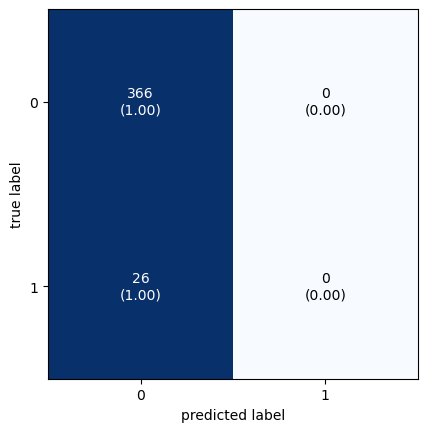

In [16]:
# create a np.array with selected_model values

conf_matrix = np.array([[evaluation_counts_output['True Negatives'].values[0], evaluation_counts_output['False Positives'].values[0]],
                [evaluation_counts_output['False Negatives'].values[0], evaluation_counts_output['True Positives'].values[0]]])

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix,
    show_absolute=True,
    show_normed=True
)

print(evaluation_score_output[['Accuracy', 'Precision', 'Recall', 'F1-score']])
plt.show()

### **Transformations Report**

In [17]:
print('FEATURE REMOVAL')
print(feature_removal_report1)
print(feature_removal_report2)
print(feature_removal_report3)
print(feature_removal_report4)
print(feature_removal_report5)
print(feature_removal_report6)
print('------------------------------------------')
print('OUTLIER REMOVAL')
print(outlier_removal_report0)
print(outlier_removal_report1)
print('------------------------------------------')
print('SCALING')
print(scaling_report0)
print('------------------------------------------')
print('IMPUTATION')
print(imputation_report0)
print(imputation_report1)
print(imputation_report2)
print('------------------------------------------')
print('FEATURE SELECTION')
print(feature_selection_report0)
print(feature_selection_report1)
print('------------------------------------------')
print('IMBALANCE TREATMENT')
print(imbalance_report0)
print(imbalance_report1)
print(imbalance_report2)

FEATURE REMOVAL
('the number of columns dropped due to duplications is: ', 104)
('the number of columns dropped due to missing values is: ', 28)
('the number of columns dropped due to low variance is: ', 189)
('the number of columns dropped due to high correlation is: ', 90)
('Total number of columns to be dropped is: ', 411)
('New shape of the dataframe is: ', (1175, 179))
------------------------------------------
OUTLIER REMOVAL
No z-score threshold was selected
No outliers were removed from the dataset
------------------------------------------
SCALING
The dataframe has not been scaled
------------------------------------------
IMPUTATION
('Number of missing values before imputation: ', 1196)
median imputation has been applied
('Number of missing values after imputation: ', 0)
------------------------------------------
FEATURE SELECTION
No feature selection has been applied
('Shape of the training set after no feature selection: ', (1175, 179))
-------------------------------------